In [1]:
import os, sys
import glob as glob
import numpy as np
import logging
import warnings
import pickle
import MDAnalysis as mda
from pprint import pprint

#from openeye import oechem
from openff.qcsubmit.common_structures import QCSpec, PCMSettings, DriverEnum, SCFProperties
from openff.qcsubmit.factories import OptimizationDatasetFactory, BasicDatasetFactory
from openff.qcsubmit.workflow_components import ComponentResult
from openff.toolkit.topology import Molecule
from qcelemental.models.results import WavefunctionProtocolEnum
from tqdm import tqdm

In [2]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import rdBase
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.addStereoAnnotation = True

print(rdBase.rdkitVersion)

2022.03.3


In [3]:
from openff.toolkit._version import get_versions
get_versions()

{'date': '2022-04-25T11:55:39-0400',
 'dirty': False,
 'error': None,
 'full-revisionid': '37d6806bbb9d0d8aacb7221891b5d86dcdee014b',
 'version': '0.10.6'}

In [4]:
# Warnings that tell us we have undefined stereo and charged molecules
logging.getLogger("openff.toolkit").setLevel(logging.ERROR)
warnings.simplefilter("ignore")

In [5]:
from openff.toolkit.utils import GLOBAL_TOOLKIT_REGISTRY
from openff.toolkit.utils import OpenEyeToolkitWrapper, RDKitToolkitWrapper, AmberToolsToolkitWrapper, BuiltInToolkitWrapper
print(GLOBAL_TOOLKIT_REGISTRY.registered_toolkits)

[ToolkitWrapper around The RDKit version 2022.03.3, ToolkitWrapper around AmberTools version 22.0, ToolkitWrapper around Built-in Toolkit version None]


# Dataset Preparation

In [6]:
with open('rdmols_loopMOTIFS.pkl', 'rb') as db:
    rdmols = pickle.load(db)

In [9]:
print("# of entries")
print("total: {}".format(len(rdmols)))

# of entries
total: 40835


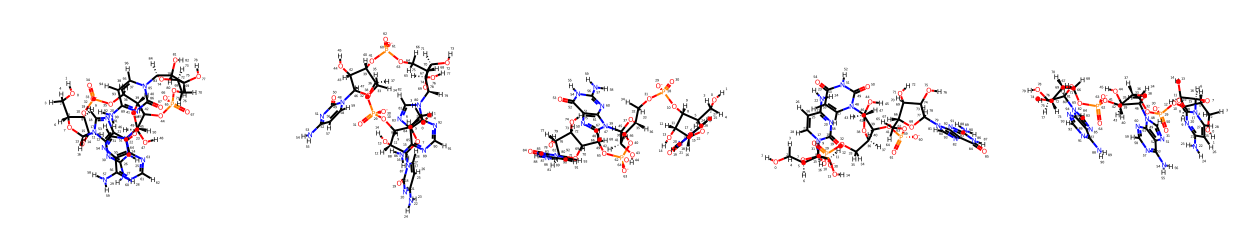

In [10]:
_rdmols = rdmols[:5]
#Draw.MolsToGridImage(_rdmols, subImgSize=(250,250), molsPerRow=5, legends=[ r.GetProp('_Name') for r in _rdmols ])
Draw.MolsToGridImage(_rdmols, subImgSize=(250,250), molsPerRow=5)

Load rdkit molecules

In [11]:
mols = [ Molecule.from_rdkit(rdmol, allow_undefined_stereo=False, hydrogens_are_explicit=True) for rdmol in tqdm(rdmols) ]

100%|███████████████████████████████████████████████████████████████████████████| 40835/40835 [1:13:45<00:00,  9.23it/s]


We need to some workaround to solve sterecenters of backbone phosphorouses that are defined randomly (because one bond to O is technically single and the other is double)  
[Isomorphic Assertion Error](https://github.com/choderalab/rna_bgsu/issues/1)

In [12]:
for mol in mols:
    for atom in mol.atoms:
        if (atom.atomic_number == 15) and (atom.stereochemistry is not None):
            atom.stereochemistry = None
            #print('stripping P stereo')

In [13]:
# check if stereocenters are same as the reference
for i, mol in enumerate(mols):
    atom = mol.atoms
    s = [ a.stereochemistry for a in atom if a.stereochemistry is not None ]
    s = ''.join(s)       

    # trinucleotides
    if len(s) == 12:
        stereo_reference="RSRRRSRRRSRR"
    else:
        raise ValueError("number of stereocenter does not match reference")
        
    assert s == stereo_reference, "{} does not match expected sequence (expected {} but got {})".format(rdmols[i].GetProp('_Name'), stereo_reference, s)

In [14]:
#mols[0].visualize()

In [15]:
#Molecule.to_smiles(mols[0])

Prepare the main dataset from the molecule list

In [16]:
factory = BasicDatasetFactory(
        driver=DriverEnum.gradient, 
        qc_specifications = {
            'default': QCSpec(
                method='b3lyp-d3bj', 
                basis='dzvp', 
                program='psi4', 
                spec_name='default', 
                spec_description='Standard OpenFF optimization quantum chemistry specification', 
                store_wavefunction="none", 
                implicit_solvent=None, 
                maxiter=200, 
                scf_properties=[SCFProperties.Dipole, SCFProperties.Quadrupole], 
        ), 
    }
)
    


In [17]:
dataset = factory.create_dataset(dataset_name="RNA Trinucleotide Single Point Dataset v1.0", 
                                 molecules=mols, 
                                 tagline="QM dataset for ML", 
                                 description="This is a single point energy calculations of RNA trinucleotides. Detailed description on how the data is generated can be found at https://github.com/choderalab/rna-bgsu-trinucleotide")

Preparation                   :   0%|                    | 0/64 [00:00<?, ?it/s][10:49:18] WARNING: Proton(s) added/removed

[10:49:19] WARNING: Proton(s) added/removed

Preparation                   :   2%|▏           | 1/64 [00:07<07:55,  7.54s/it][10:49:24] WARNING: Proton(s) added/removed

[10:49:24] WARNING: Proton(s) added/removed

Preparation                   :   3%|▍           | 2/64 [00:10<05:12,  5.05s/it][10:49:27] WARNING: Proton(s) added/removed

[10:49:27] WARNING: Proton(s) added/removed

Preparation                   :   5%|▌           | 3/64 [00:12<03:46,  3.72s/it][10:49:30] WARNING: Proton(s) added/removed

[10:49:30] WARNING: Proton(s) added/removed

Preparation                   :   6%|▊           | 4/64 [00:17<03:53,  3.89s/it][10:49:36] WARNING: Proton(s) added/removed

[10:49:36] WARNING: Proton(s) added/removed

Preparation                   :   8%|▉           | 5/64 [00:24<05:04,  5.15s/it][10:49:45] WARNING: Proton(s) added/removed

[10:49:46] WARNING: Proto

Make sure the molecules in the dataset match the input molecules

In [18]:
old_smiles = { Molecule.from_rdkit(rdmol, allow_undefined_stereo=True).to_smiles(isomeric=False) for rdmol in tqdm(rdmols) }
new_smiles = { molecule.to_smiles(isomeric=False) for molecule in tqdm(dataset.molecules) }

assert len(old_smiles.symmetric_difference(new_smiles)) == 0

100%|████████████████████████████████████████████████████████████████| 40835/40835 [45:40<00:00, 14.90it/s]
64it [00:37,  1.71it/s]


Describe the molecule in the dataset

In [19]:
confs = np.array([len(mol.conformers) for mol in dataset.molecules])

print("Number of unique molecules       ", dataset.n_molecules)
print("Number of filtered molecules     ", dataset.n_filtered)
print("Number of conformers             ", dataset.n_records)
print("Number of conformers min mean max",
      confs.min(), "{:6.2f}".format(confs.mean()), confs.max())


from rdkit.Chem import Descriptors
masses = []
for molecule in dataset.molecules:
    rdmol = molecule.to_rdkit()
    mass = Descriptors.MolWt(rdmol)
    masses.append(mass)

print(f'Mean molecular weight: {np.mean(np.array(masses)):.2f}')
print(f'Max molecular weight: {np.max(np.array(masses)):.2f}')
print("Charges:", sorted(set(m.total_charge/m.total_charge.unit for m in dataset.molecules)))

Number of unique molecules        64
Number of filtered molecules      0
Number of conformers              40835
Number of conformers min mean max 185 638.05 1622
Mean molecular weight: 900.35
Max molecular weight: 971.64
Charges: [-2.0]


Describe the dataset

In [20]:
dataset.metadata.submitter = 'Kenichiro Takaba'
dataset.metadata.long_description_url = 'https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2022-10-21-RNA-trinucleotide-single-points'

In [21]:
pprint(dataset.metadata.dict())

{'collection_type': 'DataSet',
 'creation_date': datetime.date(2022, 10, 21),
 'dataset_name': 'RNA Trinucleotide Single Point Dataset v1.0',
 'elements': {'O', 'N', 'C', 'H', 'P'},
 'long_description': 'This is a single point energy calculations of RNA '
                     'trinucleotides. Detailed description on how the data is '
                     'generated can be found at '
                     'https://github.com/choderalab/rna-bgsu-trinucleotide',
 'long_description_url': HttpUrl('https://github.com/openforcefield/qca-dataset-submission/tree/master/submissions/2022-10-21-RNA-trinucleotide-single-points', scheme='https', host='github.com', tld='com', host_type='domain', port='443', path='/openforcefield/qca-dataset-submission/tree/master/submissions/2022-10-21-RNA-trinucleotide-single-points'),
 'short_description': 'QM dataset for ML',
 'submitter': 'Kenichiro Takaba'}


In [22]:
for spec, obj in dataset.qc_specifications.items():
    print("Spec:", spec)
    pprint(obj.dict())

Spec: default
{'basis': 'dzvp',
 'implicit_solvent': None,
 'keywords': None,
 'maxiter': 200,
 'method': 'b3lyp-d3bj',
 'program': 'psi4',
 'scf_properties': ['dipole', 'quadrupole'],
 'spec_description': 'Standard OpenFF optimization quantum chemistry '
                     'specification',
 'spec_name': 'default',
 'store_wavefunction': 'none'}


In [23]:
pprint(dataset.qc_specifications)

{'default': QCSpec(method='b3lyp-d3bj', basis='dzvp', program='psi4', spec_name='default', spec_description='Standard OpenFF optimization quantum chemistry specification', store_wavefunction=<WavefunctionProtocolEnum.none: 'none'>, implicit_solvent=None, maxiter=200, scf_properties=[<SCFProperties.Dipole: 'dipole'>, <SCFProperties.Quadrupole: 'quadrupole'>], keywords=None)}


Export the dataset

In [24]:
dataset.export_dataset("dataset.json.bz2")
dataset.molecules_to_file("dataset.smi", "smi")

In [ ]:
#dataset.visualize("dataset.pdf")